<a href="https://colab.research.google.com/github/darthchako/ProyectoPC1/blob/master/NOTEBOOKS/Copy_of_practicaFinalSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Se ha realizado una memoria en PDF para explicar el proyecto. 
En este [enlace](https://liveuem-my.sharepoint.com/:f:/g/personal/22028598_live_uem_es/Egb7FT8W5VZGjilflQje40gBjqtl-Z2eqbx_vnI52aw32w?e=tDrjQK) encontrará la memoria en pdf y el archivo .csv para poder probar el modelo correctamente.

In [ ]:

import numpy as np 
import pandas as pd 
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

import tensorflow
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pickle


In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Colección de datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Archivos/SPAM.csv")

In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Limpieza de los datos

Limpiamos primero la variable categoria en vez de tener ham y spam lo cambiamos por 0 y 1 respectivamente;

HAM = 0;    
SPAM = 1;


In [ ]:
df['Category'] = df['Category'].replace(['ham','spam'],[0,1]) 

Renombramos las variables de los datos

In [ ]:
df.rename(columns = {'Category':'Tipo','Message' :'Texto'} , inplace= True )

In [ ]:
df.head()

,Tipo,Texto
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Comprobamos si existen datos nulos.





In [ ]:
df.isnull().sum()

Tipo     0
Texto    0
dtype: int64

# Exploración de datos

Observamos gráficamente la cantidad de datos según su tipo.
Vemos que la mayoria de los datos que vamos a tratar son HAM(buenos) y spam solo hay un pequeño porcentaje

In [ ]:
df['Tipo'].value_counts()

0    4825
1     747
Name: Tipo, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


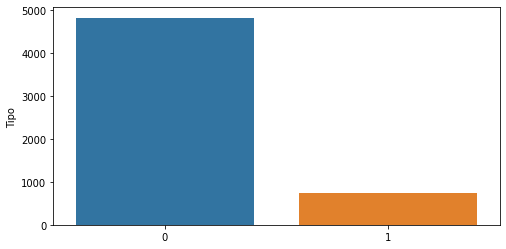

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(df['Tipo'].value_counts().index, df['Tipo'].value_counts())

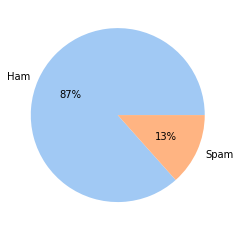

In [ ]:
label = ['Ham','Spam']
colors = sns.color_palette('pastel')[0:5]
plt.pie(df['Tipo'].value_counts(),labels = label, colors = colors, autopct='%.0f%%')
plt.show()

Vamos a mostrar mediante una nube de palabras las palabras más repetidas en cada caso.

Palabras que más se repiten en SPAM:


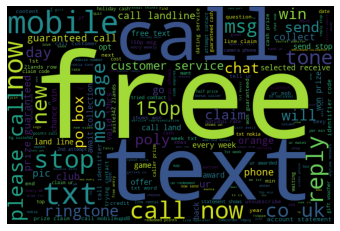

Palabras que más se repiten en HAM:


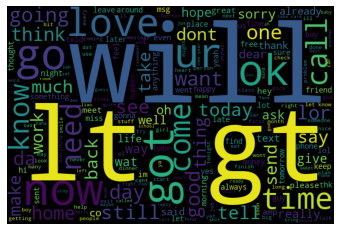

In [ ]:

def visualize(label):
    words=''
    for msg in df[df['Tipo'] == label]['Texto']:
        msg = msg.lower()
        words+=msg + ''
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Palabras que más se repiten en SPAM:")
visualize(1) #mensajes spam se indica con 1

print("Palabras que más se repiten en HAM:")
visualize(0) #mensajes ham se indica con 0

In [ ]:
temp = df.copy() # guardamos los datos en una variable temporal

Comprobamos la longitud de cada mensaje para valorar que tipo de mensaje contiene más caracteres.

In [ ]:
temp['longitud_mensaje'] = temp['Texto'].apply(lambda x:len(x.split())) 
temp.head()

,Tipo,Texto,longitud_palabra,longitud_mensaje
0,0,"Go until jurong point, crazy.. Available only ...",20,20
1,0,Ok lar... Joking wif u oni...,6,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,28
3,0,U dun say so early hor... U c already then say...,11,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13,13


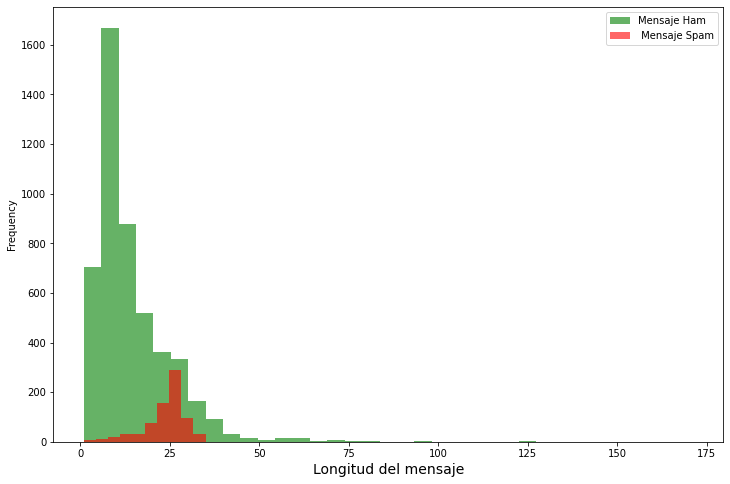

In [ ]:
plt.figure(figsize=(12, 8))
temp[temp.Tipo==0].longitud_palabra.plot(bins=35, kind='hist', color='green', 
                                       label='Mensaje Ham ', alpha=0.6)
temp[temp.Tipo == 1].longitud_palabra.plot(kind='hist', color='red', 
                                       label=' Mensaje Spam', alpha=0.6)
plt.legend()
plt.xlabel("Longitud del mensaje", fontsize = 14)
plt.show()


*   Eliminar signos de puntuación 
*   Eliminar stopword
*   Eliminar URLS
En el metodo preprocesado cambiamos todos los datos eliminando lo anterior

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def preProcesado(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df["Texto"] = df.Texto.map(preProcesado)

In [ ]:
df.head()

,Tipo,Texto
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


# Entrenamiento de modelo

In [ ]:
maxSeq = len(df["Texto"][0])
for i in range (0,len(df["Texto"])):
    try:
        cur = len(df["Texto"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

In [ ]:
from collections import Counter

def contar_palabras(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


contador = contar_palabras(df.Texto)

MAX_NB_WORDS = len(contador)
MAX_SEQUENCE_LENGTH = maxSeq


In [ ]:
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['Texto'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X = tokenizer.texts_to_sequences(df['Texto'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Forma del tensor de datos:', X.shape)

Forma del tensor de datos: (5572, 442)


In [ ]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df['Tipo'] = labelencoder.fit_transform(df['Tipo'])
Y = df['Tipo'].values
print('Forma del tensor de datos:', Y.shape)

Forma del tensor de datos: (5572,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4179, 442) (4179,)
(1393, 442) (1393,)


In [ ]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
modelo = tensorflow.keras.models.Sequential()
modelo.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
modelo.add(layers.LSTM(32))
modelo.add(layers.Dense(1, activation='sigmoid'))
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 512

history = modelo.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/20
7/7 [==============================] - 4s 213ms/step - loss: 0.6534 - accuracy: 0.8588 - val_loss: 0.5897 - val_accuracy: 0.8696
Epoch 2/20
7/7 [==============================] - 1s 101ms/step - loss: 0.5166 - accuracy: 0.8723 - val_loss: 0.3999 - val_accuracy: 0.8589
Epoch 3/20
7/7 [==============================] - 1s 95ms/step - loss: 0.3309 - accuracy: 0.8675 - val_loss: 0.3313 - val_accuracy: 0.8589
Epoch 4/20
7/7 [==============================] - 1s 95ms/step - loss: 0.2868 - accuracy: 0.8675 - val_loss: 0.2640 - val_accuracy: 0.8648
Epoch 5/20
7/7 [==============================] - 1s 95ms/step - loss: 0.2097 - accuracy: 0.9076 - val_loss: 0.2142 - val_accuracy: 0.9414
Epoch 6/20
7/7 [==============================] - 1s 93ms/step - loss: 0.1625 - accuracy: 0.9617 - val_loss: 0.1722 - val_accuracy: 0.9486
Epoch 7/20
7/7 [==============================] - 1s 94ms/step - loss: 0.1209 - accuracy: 0.9683 - val_loss: 0.1515 - val_accuracy: 0.9617
Epoch 8/20
7/7 [=========

# Evaluación del modelo

In [ ]:
print(history.model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 442, 100)          707100    
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 724,157
Trainable params: 724,157
Non-trainable params: 0
_________________________________________________________________
None


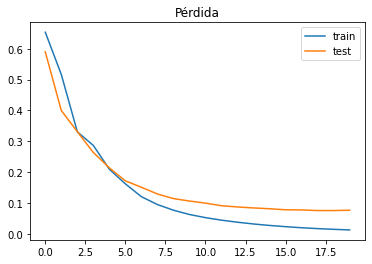

In [ ]:
plt.title('Pérdida')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

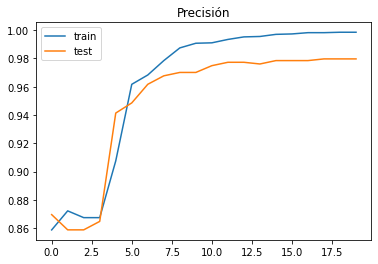

In [ ]:
plt.title('Precisión')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Pruebas del modelo

Guardamos el modelo para poder probarlo correctamente

In [ ]:
modelo.save("./Modelo Final.h5")

In [ ]:
from keras.models import load_model
loadedModel = load_model("./Modelo Final.h5")
testText = str(input("Por favor, escriba un mensaje\n"))
testText = preProcesado(testText)
testText = [testText]
with open("./tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
testText = tokenizer.texts_to_sequences(testText)
testText = pad_sequences(testText, maxlen=MAX_SEQUENCE_LENGTH)
threshold = 0.5
result = modelo.predict(testText, verbose=2)
result = result > threshold
result = result.astype(int)
if result[0] == 1:
    print("Spam")
elif result[0] == 0:
    print("Ham")

Por favor, escriba un mensaje
3 FREE TAROT TEXT! TRY FOR FREE! TEXT CHACE TO 85556
1/1 - 0s - 21ms/epoch - 21ms/step
Spam
